In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import statsmodels.formula.api as smf

# Target: measure the relationship between the change of housing rent price and entropy index of income_level groups

# 1.Data cleaning

# 1.1 clean dataset
This dataset is exported from Geolytics: Neighborhood Change Database (NACD)
(http://demographics.geolytics.com/ncdb2010/default.aspx)


### the dataset has been uploaded on:
 https://github.com/picniclin/NYC_yl5240/blob/master/geolytics_NYC_census_1990-2010.csv
 
or
https://drive.google.com/a/nyu.edu/file/d/0B2HY61hRpF-jV21KSTVsbi1wS3M/view?usp=sharing

In [2]:
df = pd.read_csv('/Users/apple/Desktop/NYC_yl5240/geolytics_NYC_census_1990-2010.csv')

In [3]:
df.shape

(2168, 146)

In [4]:
df.head()

,AREAKEY,STATE,STUSAB,INTPTLAT,INTPTLON,TCH_90_10,TCH_00_10,ZCTA5,TRCTPOP9,POVRAT9N,...,THY01001A,THY01251A,THY01501A,THY02001A,THY0M201A,MDHHY1A,MDVALHS1A,MCSMORT1A,MCSNMOR1A,MDGRENT1A
0,36005000100,36,NY,40.793492,-73.883532,0,0,11370.0,14303,0,...,0,0,0,0,0,0,0,0,0,0
1,36005000200,36,NY,40.804573,-73.856859,3,3,10473.0,2907,411,...,152,203,48,68,11,59826,392500,2661,650,1273
2,36005000400,36,NY,40.808915,-73.850488,4,4,10473.0,2260,225,...,255,97,161,96,73,71968,393700,2206,679,1330
3,36005001600,36,NY,40.818848,-73.858076,0,0,10473.0,5254,893,...,171,20,38,20,0,30355,378100,2500,649,823
4,36005001900,36,NY,40.800999,-73.909373,4,4,10454.0,1575,797,...,14,19,21,0,0,25093,0,0,539,870


In [5]:
list(df.columns)

['AREAKEY',
 'STATE',
 'STUSAB',
 'INTPTLAT',
 'INTPTLON',
 'TCH_90_10',
 'TCH_00_10',
 'ZCTA5',
 'TRCTPOP9',
 'POVRAT9N',
 'POVRAT9',
 'FAVINC9',
 'MDFAMY9',
 'FALTY109',
 'FALT159',
 'FALT209',
 'FALT259',
 'FALT309',
 'FALT359',
 'FALT409',
 'FALT499',
 'FALT609A',
 'FALT759A',
 'FALT1009',
 'FALT1259',
 'FALT1509',
 'FALTMXB9',
 'AVHHIN9',
 'MDHHY9',
 'OCCHU9',
 'VACHU9',
 'RNTOCC9',
 'OWNOCC9',
 'SPRNTOC9',
 'SPOWNOC9',
 'PRSOCU9',
 'PRSOWNU9',
 'PRSRNTU9',
 'MDVALHS9',
 'MCSMORT9',
 'MCSNMOR9',
 'MDGRENT9',
 'TRCTPOP0',
 'POVRAT0N',
 'POVRAT0',
 'FAVINC0',
 'MDFAMY0',
 'FAY0100',
 'FAY0150',
 'FAY0200',
 'FAY0250',
 'FAY0300',
 'FAY0350',
 'FAY0400',
 'FAY0450',
 'FAY0500',
 'FAY0600',
 'FAY0750',
 'FAY01000',
 'FAY01250',
 'FAY01500',
 'FAY02000',
 'FAY0M200',
 'AVHHIN0',
 'THY0100',
 'THY0150',
 'THY0200',
 'THY0250',
 'THY0300',
 'THY0350',
 'THY0400',
 'THY0450',
 'THY0500',
 'THY0600',
 'THY0750',
 'THY01000',
 'THY01250',
 'THY01500',
 'THY02000',
 'THY0M200',
 'MDHHY0',
 '

## make the column names readable

In [6]:
cols = df.columns.str.replace('TRCTPOP', 'pop')\
            .str.replace('MDFAMY','median_inc_fam_')\
            .str.replace('FAVINC', 'ave_inc_fam_')\
            .str.replace('MDHHY', 'median_inc_hh_')\
            .str.replace('AVHHIN', 'ave_inc_hh_')\
            .str.replace('FALTY', 'fam_inc_')\
            .str.replace('FALT', 'fam_inc_')\
            .str.replace('MXB', 'max_')\
            .str.replace('FAY0', 'fam_inc_')\
            .str.replace('fam_inc_M', 'fam_inc_max_')\
            .str.replace('THY0', 'hh_inc_' )\
            .str.replace('hh_inc_M', 'hh_inc_max_')\
            .str.replace('MDVALHS','median_house_value_')\
            .str.replace('MDGRENT', 'median_rent_' )\
            .str.replace('MCSMORT', 'owner_cost_mo_' )\
            .str.replace('MCSNMOR', 'owner_cost_no_mo_' )\
            .str.replace('OCCHU', 'occ_')\
            .str.replace('VACHU', 'vacant_')\
            .str.replace('RNTOCC','renter_occ_')\
            .str.replace('OWNOCC', 'owner_occ_')\
            .str.replace('SPRNTOC', 'spec_renter_occ_')\
            .str.replace('SPOWNOC', 'spec_owner_occ_')\
            .str.replace('PRSOCU', 'person_occ_')\
            .str.replace('PRSOWNU', 'person_owner_occ_')\
            .str.replace('PRSRNTU', 'person_renter_occ_')\
            .str.replace('POVRAT','poverty')\
            .str.replace('1A', '1')\
            .str.replace('9A', '9')
            
cols

Index(['AREAKEY', 'STATE', 'STUSAB', 'INTPTLAT', 'INTPTLON', 'TCH_90_10',
       'TCH_00_10', 'ZCTA5', 'pop9', 'poverty9N',
       ...
       'hh_inc_1001', 'hh_inc_1251', 'hh_inc_1501', 'hh_inc_2001',
       'hh_inc_max_201', 'median_inc_hh_1', 'median_house_value_1',
       'owner_cost_mo_1', 'owner_cost_no_mo_1', 'median_rent_1'],
      dtype='object', length=146)

In [7]:
df.columns = cols

df.rename(columns = {'AREAKEY' : 'census_tract',
                     'STATE':'state','STUSAB':'abb.',
                     'TCH_90_10':'tract_change_90', 'TCH_00_10':'tract_change_00',
                    'INTPTLAT':'lat', 'INTPTLON':'lon'}, inplace = True)
df.columns

Index(['census_tract', 'state', 'abb.', 'lat', 'lon', 'tract_change_90',
       'tract_change_00', 'ZCTA5', 'pop9', 'poverty9N',
       ...
       'hh_inc_1001', 'hh_inc_1251', 'hh_inc_1501', 'hh_inc_2001',
       'hh_inc_max_201', 'median_inc_hh_1', 'median_house_value_1',
       'owner_cost_mo_1', 'owner_cost_no_mo_1', 'median_rent_1'],
      dtype='object', length=146)

In [8]:
df = df.dropna()
df.ZCTA5 = df.ZCTA5.astype('int')
df.shape

(2157, 146)

In [9]:
## delete the observation, i.e. census tract, with 0 median rent or 0 median families income
df = df[~((df.median_rent_0 == 0)| (df.median_rent_9 == 0)|(df.median_rent_1 == 0)|\
         (df.median_inc_fam_9 == 0)| (df.median_inc_fam_9 == 0)|(df.median_inc_fam_1 == 0))]
## drop the redundant columns
df.drop(['state', 'abb.','tract_change_90','tract_change_00'], axis = 1, inplace = True)
df.head()

,census_tract,lat,lon,ZCTA5,pop9,poverty9N,poverty9,ave_inc_fam_9,median_inc_fam_9,fam_inc_109,...,hh_inc_1001,hh_inc_1251,hh_inc_1501,hh_inc_2001,hh_inc_max_201,median_inc_hh_1,median_house_value_1,owner_cost_mo_1,owner_cost_no_mo_1,median_rent_1
1,36005000200,40.804573,-73.856859,10473,2907,411,0.142067,45267.28710,38711,29,...,152,203,48,68,11,59826,392500,2661,650,1273
2,36005000400,40.808915,-73.850488,10473,2260,225,0.100089,43694.20068,40484,19,...,255,97,161,96,73,71968,393700,2206,679,1330
3,36005001600,40.818848,-73.858076,10473,5254,893,0.179245,30042.84776,24732,142,...,171,20,38,20,0,30355,378100,2500,649,823
4,36005001900,40.800999,-73.909373,10454,1575,797,0.506032,23377.47813,24823,50,...,14,19,21,0,0,25093,0,0,539,870
5,36005002000,40.817580,-73.866096,10473,9110,3423,0.375741,25062.06250,18762,284,...,180,161,0,45,12,24939,398100,2185,715,455


In [10]:
df.shape

(2089, 142)

## 1.2 find the PUMA, NAT information for each census tract

### the CensusTract/NTA/PUMA Equivalencies table could be found on this [link](https://www1.nyc.gov/site/planning/data-maps/nyc-population/geographic-reference.page)
 the downloaded linkage is https://www1.nyc.gov/assets/planning/download/office/data-maps/nyc-population/census2010/nyc2010census_tabulation_equiv.xlsx
 
This xlsx includes two tables. Split it into two csv by excel.
### The two csv files have been uploaded on:
https://github.com/picniclin/NYC_yl5240


In [11]:
df_conv1 = pd.read_csv('/Users/apple/Desktop/NYC_yl5240/data/2010CensusTract_PUMA_NTA.csv')
df_conv2 = pd.read_csv('/Users/apple/Desktop/NYC_yl5240/data/2010PUMA_NTA.csv')

In [12]:
## df_conv1 is the conversion table between census tract and PUMA/NTA
df_conv1.head()

,Borough,2010CensusTract,PUMA,NTA_Code,NTA_Name
0,Bronx,31000,3704,BX31,Allerton-Pelham Gardens
1,Bronx,31200,3704,BX31,Allerton-Pelham Gardens
2,Bronx,31400,3704,BX31,Allerton-Pelham Gardens
3,Bronx,31600,3704,BX31,Allerton-Pelham Gardens
4,Bronx,31800,3704,BX31,Allerton-Pelham Gardens


In [13]:
## df_conv2 is the conversion table between PUMA and NTA
df_conv2.head()

,Borough,PUMA,PUMA_CommunityDistrict,NTA_Code,NTA_Name
0,Bronx,3701,BX Community District 8,BX22,North Riverdale-Fieldston-Riverdale
1,Bronx,3701,BX Community District 8,BX28,Van Cortlandt Village
2,Bronx,3701,BX Community District 8,BX29,Spuyten Duyvil-Kingsbridge
3,Bronx,3702,BX Community District 12,BX03,Eastchester-Edenwald-Baychester
4,Bronx,3702,BX Community District 12,BX44,Williamsbridge-Olinville


In [14]:
len(df_conv1), len(df_conv2)

(2168, 219)

In [15]:
## In df_conv2, we could extract the PUMA list, including PUMA code and PUMA_CommunityDistrict
df_PUMA = df_conv2.iloc[:,1:3].drop_duplicates().reset_index(drop = True)
df_PUMA

,PUMA,PUMA_CommunityDistrict
0,3701,BX Community District 8
1,3702,BX Community District 12
2,3703,BX Community District 10
3,3704,BX Community District 11
4,3705,BX Community Districts 3 & 6
5,3706,BX Community District 7
6,3707,BX Community District 5
7,3708,BX Community District 4
8,3709,BX Community District 9
9,3710,BX Community Districts 1 & 2


In [16]:
df_conv3 = pd.DataFrame([['Bronx', '36005'],['Brooklyn','36047'],['Manhattan','36061'], 
              ['Queens','36081'], ['Staten Island', '36085']], columns=['Borough','BroCode'])
df_conv3

,Borough,BroCode
0,Bronx,36005
1,Brooklyn,36047
2,Manhattan,36061
3,Queens,36081
4,Staten Island,36085


In [17]:
df_tract = df_conv1.merge(df_conv2.rename(columns={'PUMA Code':'PUMA'}), 
               on = ['NTA_Code', 'NTA_Name', 'Borough', 'PUMA']).merge(df_conv3, on = 'Borough')

df_tract.head()

,Borough,2010CensusTract,PUMA,NTA_Code,NTA_Name,PUMA_CommunityDistrict,BroCode
0,Bronx,31000,3704,BX31,Allerton-Pelham Gardens,BX Community District 11,36005
1,Bronx,31200,3704,BX31,Allerton-Pelham Gardens,BX Community District 11,36005
2,Bronx,31400,3704,BX31,Allerton-Pelham Gardens,BX Community District 11,36005
3,Bronx,31600,3704,BX31,Allerton-Pelham Gardens,BX Community District 11,36005
4,Bronx,31800,3704,BX31,Allerton-Pelham Gardens,BX Community District 11,36005


In [18]:
df_tract['census_tract']  = (df_tract.BroCode +\
                        df_tract['2010CensusTract'].apply(lambda x : str(x).zfill(6))).astype(int)

In [19]:
df_tract = df_tract.iloc[:,[0,-1,2,-3,3,4]]
df_tract.head()

,Borough,census_tract,PUMA,PUMA_CommunityDistrict,NTA_Code,NTA_Name
0,Bronx,36005031000,3704,BX Community District 11,BX31,Allerton-Pelham Gardens
1,Bronx,36005031200,3704,BX Community District 11,BX31,Allerton-Pelham Gardens
2,Bronx,36005031400,3704,BX Community District 11,BX31,Allerton-Pelham Gardens
3,Bronx,36005031600,3704,BX Community District 11,BX31,Allerton-Pelham Gardens
4,Bronx,36005031800,3704,BX Community District 11,BX31,Allerton-Pelham Gardens


In [20]:
df_tract.shape

(2167, 6)

In [21]:
# check does the conversion table contain all the census tract in dataset df
len(set(df['census_tract']) - set(df_tract['census_tract'])), \
len(set(df_tract['census_tract']) - set(df['census_tract']) ), \
len(set(df['census_tract']))

(0, 78, 2089)

#### Yes, the conversion table contain all the census tract in dataset df.

## 1.3 conbine the conversion table into dataset, to add the PUMA and NTA information

In [22]:
df_all = df.merge(df_tract, on = 'census_tract')

df_all.head()

,census_tract,lat,lon,ZCTA5,pop9,poverty9N,poverty9,ave_inc_fam_9,median_inc_fam_9,fam_inc_109,...,median_inc_hh_1,median_house_value_1,owner_cost_mo_1,owner_cost_no_mo_1,median_rent_1,Borough,PUMA,PUMA_CommunityDistrict,NTA_Code,NTA_Name
0,36005000200,40.804573,-73.856859,10473,2907,411,0.142067,45267.28710,38711,29,...,59826,392500,2661,650,1273,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park
1,36005000400,40.808915,-73.850488,10473,2260,225,0.100089,43694.20068,40484,19,...,71968,393700,2206,679,1330,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park
2,36005001600,40.818848,-73.858076,10473,5254,893,0.179245,30042.84776,24732,142,...,30355,378100,2500,649,823,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park
3,36005001900,40.800999,-73.909373,10454,1575,797,0.506032,23377.47813,24823,50,...,25093,0,0,539,870,Bronx,3710,BX Community Districts 1 & 2,BX39,Mott Haven-Port Morris
4,36005002000,40.817580,-73.866096,10473,9110,3423,0.375741,25062.06250,18762,284,...,24939,398100,2185,715,455,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park


In [23]:
# change the colomn location of df_cov's colomns
df_all = pd.concat([df_all.iloc[:,[0]], df_all.iloc[:,-5:], df_all.iloc[:,1:-5]], axis = 1)
df_all.head()

,census_tract,Borough,PUMA,PUMA_CommunityDistrict,NTA_Code,NTA_Name,lat,lon,ZCTA5,pop9,...,hh_inc_1001,hh_inc_1251,hh_inc_1501,hh_inc_2001,hh_inc_max_201,median_inc_hh_1,median_house_value_1,owner_cost_mo_1,owner_cost_no_mo_1,median_rent_1
0,36005000200,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.804573,-73.856859,10473,2907,...,152,203,48,68,11,59826,392500,2661,650,1273
1,36005000400,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.808915,-73.850488,10473,2260,...,255,97,161,96,73,71968,393700,2206,679,1330
2,36005001600,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.818848,-73.858076,10473,5254,...,171,20,38,20,0,30355,378100,2500,649,823
3,36005001900,Bronx,3710,BX Community Districts 1 & 2,BX39,Mott Haven-Port Morris,40.800999,-73.909373,10454,1575,...,14,19,21,0,0,25093,0,0,539,870
4,36005002000,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.817580,-73.866096,10473,9110,...,180,161,0,45,12,24939,398100,2185,715,455


In [24]:
df_all.shape, df.shape

((2089, 147), (2089, 142))

### We have 2089 census tracts for analysis.

# 2. split the dataset into several sub-tables

## 2.1 Geographies data table
according to http://guides.newman.baruch.cuny.edu/nyc_data/nbhoods, New York City neighborhood census data could use Public Use Microdata Areas (PUMAs).


In [25]:
# the sub-table of census tract information, including census tract id, latitude, longitude, and ZCTA.
# df_dataset_tract is part of df_tract , accrdance with the observations of dataset
# also three more variables than df_tract: lat, lon, ZCTA5 
df_dataset_tract = df_all.iloc[:, :9]
df_dataset_tract.head()

,census_tract,Borough,PUMA,PUMA_CommunityDistrict,NTA_Code,NTA_Name,lat,lon,ZCTA5
0,36005000200,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.804573,-73.856859,10473
1,36005000400,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.808915,-73.850488,10473
2,36005001600,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.818848,-73.858076,10473
3,36005001900,Bronx,3710,BX Community Districts 1 & 2,BX39,Mott Haven-Port Morris,40.800999,-73.909373,10454
4,36005002000,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.817580,-73.866096,10473


In [26]:
df_dataset_tract.shape

(2089, 9)

## 2.2 Tables for different years

In [27]:
df_1990 = pd.concat([df.iloc[:,[0]], df.iloc[:, 8:42]],axis =1)
df_2000 = pd.concat([df.iloc[:,[0]], df.iloc[:, 42:94]],axis =1)
df_2010 = pd.concat([df.iloc[:,[0]], df.iloc[:, 94:]],axis =1)
df_1990.shape, df_2000.shape, df_2010.shape

((2089, 35), (2089, 53), (2089, 49))

In [28]:
df_1990.head()

,census_tract,median_inc_fam_9,fam_inc_109,fam_inc_159,fam_inc_209,fam_inc_259,fam_inc_309,fam_inc_359,fam_inc_409,fam_inc_499,...,person_owner_occ_9,person_renter_occ_9,median_house_value_9,owner_cost_mo_9,owner_cost_no_mo_9,median_rent_9,pop0,poverty0N,poverty0,ave_inc_fam_0
1,36005000200,38711,29,29,12,31,20,32,31,84,...,1845,1055,136500,1006,204,742,3505,703,0.202477,50763.54348
2,36005000400,40484,19,17,11,34,1,50,50,89,...,1662,593,163234,1066,301,535,3354,437,0.131508,48306.41829
3,36005001600,24732,142,28,124,84,41,165,39,161,...,885,4116,156800,805,302,466,5208,1112,0.221735,36442.53563
4,36005001900,24823,50,39,0,0,3,0,0,67,...,467,1002,48868,1394,82,422,1613,556,0.405248,31360.47431
5,36005002000,18762,284,201,107,60,74,131,95,203,...,1719,7380,185400,1237,193,298,9101,4118,0.459291,26817.80645


## 2.3 Income Tables

In [111]:
# the sub-table of median/avlerage families/households income
df_income = df_all.loc[:,df_all.columns[(df_all.columns == 'census_tract') |\
                                (df_all.columns == 'PUMA')|\
                              (df_all.columns.str.startswith('median_inc_')) |\
                              (df_all.columns.str.startswith('ave_inc_'))]]
df_income.head()  

ValueError: operands could not be broadcast together with shapes (142,) (147,) 

In [30]:
df_income.shape

(2089, 13)

In [31]:
df_income.describe()

,census_tract,ave_inc_fam_9,median_inc_fam_9,ave_inc_hh_9,median_inc_hh_9,ave_inc_fam_0,median_inc_fam_0,ave_inc_hh_0,median_inc_hh_0,ave_inc_fam_1,median_inc_fam_1,ave_inc_hh_1,median_inc_hh_1
count,2.089000e+03,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.00000,2089.000000,2089.000000,2089.000000
mean,3.605455e+10,46240.797301,37689.401628,39246.703235,31309.411202,63576.869583,48874.026807,54229.582025,40628.821446,85376.28443,66207.958353,72345.813173,54703.689325
std,2.594637e+07,28606.446820,18760.425689,19565.189172,13562.873547,45058.370638,28645.098401,29038.210224,18527.299709,62564.07724,39910.826453,40603.704702,25923.948148
min,3.600500e+10,0.000000,86.000000,0.000000,5360.000000,16376.090910,7354.000000,12747.077320,7863.000000,0.00000,8542.000000,0.000000,8694.000000
25%,3.604702e+10,30501.042240,24924.000000,27864.930300,21862.000000,40513.116200,30724.000000,37683.585970,27976.000000,52010.32700,40022.000000,48876.596000,36299.000000
50%,3.604712e+10,41866.927540,36218.000000,36208.754250,30417.000000,53041.525420,42590.000000,48376.129030,37936.000000,70564.74300,56726.000000,64120.604000,51127.000000
75%,3.608103e+10,53084.721130,46843.000000,46187.374640,39697.000000,69321.465430,58977.000000,62046.691640,50806.000000,93098.66200,80125.000000,82035.096000,68026.000000
max,3.608503e+10,327320.474100,150001.000000,248923.005700,147567.000000,450967.828700,200001.000000,337238.297900,174119.000000,636204.42600,250001.000000,464390.618000,232768.000000


### Since there is no household income in 1990, we prefer to choose family income data as income data

In [32]:
df_family_income = df_all.loc[:,df_all.columns[(df_all.columns == 'census_tract') | \
                                       (df_all.columns == 'PUMA')|\
                                       df_all.columns.str.startswith('fam_inc_')]]
df_family_income.head()

,census_tract,PUMA,fam_inc_109,fam_inc_159,fam_inc_209,fam_inc_259,fam_inc_309,fam_inc_359,fam_inc_409,fam_inc_499,...,fam_inc_401,fam_inc_451,fam_inc_501,fam_inc_601,fam_inc_751,fam_inc_1001,fam_inc_1251,fam_inc_1501,fam_inc_2001,fam_inc_max_201
0,36005000200,3709,29,29,12,31,20,32,31,84,...,36,142,24,77,49,136,221,60,38,0
1,36005000400,3709,19,17,11,34,1,50,50,89,...,41,60,53,174,79,206,79,145,116,46
2,36005001600,3709,142,28,124,84,41,165,39,161,...,99,78,124,19,167,129,20,29,20,0
3,36005001900,3710,50,39,0,0,3,0,0,67,...,1,32,0,22,16,12,9,21,0,0
4,36005002000,3709,284,201,107,60,74,131,95,203,...,124,62,138,119,63,103,161,0,45,12


In [33]:
df_family_income

,census_tract,PUMA,fam_inc_109,fam_inc_159,fam_inc_209,fam_inc_259,fam_inc_309,fam_inc_359,fam_inc_409,fam_inc_499,...,fam_inc_401,fam_inc_451,fam_inc_501,fam_inc_601,fam_inc_751,fam_inc_1001,fam_inc_1251,fam_inc_1501,fam_inc_2001,fam_inc_max_201
0,36005000200,3709,29,29,12,31,20,32,31,84,...,36,142,24,77,49,136,221,60,38,0
1,36005000400,3709,19,17,11,34,1,50,50,89,...,41,60,53,174,79,206,79,145,116,46
2,36005001600,3709,142,28,124,84,41,165,39,161,...,99,78,124,19,167,129,20,29,20,0
3,36005001900,3710,50,39,0,0,3,0,0,67,...,1,32,0,22,16,12,9,21,0,0
4,36005002000,3709,284,201,107,60,74,131,95,203,...,124,62,138,119,63,103,161,0,45,12
5,36005002300,3710,201,39,76,69,43,91,50,49,...,48,44,22,83,52,74,27,28,0,0
6,36005002500,3710,228,53,41,35,48,57,73,31,...,40,47,24,27,83,46,21,0,0,9
7,36005002701,3710,147,32,48,28,30,29,12,37,...,38,51,0,16,20,49,26,0,26,0
8,36005002702,3710,268,5,6,5,11,32,7,34,...,32,26,63,0,0,64,6,0,15,0
9,36005002800,3709,67,0,67,141,39,210,135,234,...,64,123,31,185,104,230,83,76,75,14


In [34]:
# the tables of different groups of families income level
df_family_income_1990 = df_family_income.loc[:,
                        df_family_income.columns[(df_family_income.columns == 'census_tract') |\
                                                    df_family_income.columns.str.endswith('9')]]

df_family_income_2000 = df_family_income.loc[:,
                        df_family_income.columns[(df_family_income.columns == 'census_tract') |\
                                                    df_family_income.columns.str.endswith('0')]]

df_family_income_2010 = df_family_income.loc[:,
                        df_family_income.columns[(df_family_income.columns == 'census_tract') |\
                                                    df_family_income.columns.str.endswith('1')]]

 
df_family_income_1990.shape, df_family_income_2000.shape, df_family_income_2010.shape

((2089, 15), (2089, 17), (2089, 17))

In [35]:
df_family_income_1990.head()

,census_tract,fam_inc_109,fam_inc_159,fam_inc_209,fam_inc_259,fam_inc_309,fam_inc_359,fam_inc_409,fam_inc_499,fam_inc_609,fam_inc_759,fam_inc_1009,fam_inc_1259,fam_inc_1509,fam_inc_max_9
0,36005000200,29,29,12,31,20,32,31,84,75,59,68,35,18,2
1,36005000400,19,17,11,34,1,50,50,89,71,58,62,28,1,1
2,36005001600,142,28,124,84,41,165,39,161,69,70,45,11,0,0
3,36005001900,50,39,0,0,3,0,0,67,26,10,0,0,0,0
4,36005002000,284,201,107,60,74,131,95,203,158,40,84,8,0,13


## 2.4 Housing tables, including data of house value and rent

In [36]:
# the sub-table of housing price and rent
df_house = df.loc[:,df.columns[(df.columns == 'census_tract') |\
                              (df.columns.str.startswith('median_rent_')) |\
                              (df.columns.str.startswith('median_house_'))]]
df_house.head()

,census_tract,median_house_value_9,median_rent_9,median_house_value_0,median_rent_0,median_house_value_1,median_rent_1
1,36005000200,136500,742,147500,730,392500,1273
2,36005000400,163234,535,157610,643,393700,1330
3,36005001600,156800,466,177000,558,378100,823
4,36005001900,48868,422,145960,461,0,870
5,36005002000,185400,298,177600,266,398100,455


In [37]:
df_house.shape

(2089, 7)

In [38]:
df_house.describe()

,census_tract,median_house_value_9,median_rent_9,median_house_value_0,median_rent_0,median_house_value_1,median_rent_1
count,2.089000e+03,2089.000000,2089.000000,2.089000e+03,2089.000000,2.089000e+03,2089.000000
mean,3.605455e+10,170909.090953,544.198181,2.233565e+05,753.071326,5.070657e+05,1151.020105
std,2.594637e+07,110359.984751,150.069074,1.826276e+05,231.835763,2.214706e+05,331.293631
min,3.600500e+10,0.000000,140.000000,0.000000e+00,175.000000,0.000000e+00,231.000000
25%,3.604702e+10,118204.000000,453.000000,1.604000e+05,644.000000,3.981000e+05,964.000000
50%,3.604712e+10,171500.000000,531.000000,1.964000e+05,740.000000,4.941000e+05,1120.000000
75%,3.608103e+10,218689.000000,629.000000,2.508000e+05,834.000000,6.275000e+05,1308.000000
max,3.608503e+10,500001.000000,1001.000000,1.000001e+06,2001.000000,1.000001e+06,2001.000000


# 3. Analysis based on census tract

## 1）create the table for relationship analysis

The variables we need are median family income, median rent, families with different income level

## Look at a whole view of income and rent
To compare the 1990 data, we choose the family income, not household income.

In [115]:
df2 = df_all.loc[:,df_all.columns[(df_all.columns == 'census_tract') |\
                          (df_all.columns == 'PUMA') |\
                          (df_all.columns.str.startswith('median_inc_fam'))|\
                          (df_all.columns.str.startswith('median_rent')) ]]

In [116]:
df2.head()

,census_tract,PUMA,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1
0,36005000200,3709,38711,742,50817,730,58368,1273
1,36005000400,3709,40484,535,41019,643,73148,1330
2,36005001600,3709,24732,466,30104,558,33555,823
3,36005001900,3710,24823,422,23671,461,25489,870
4,36005002000,3709,18762,298,19694,266,30817,455


In [117]:
df2['rent_income_ratio_9'] = df2['median_rent_9'] * 12/df2['median_inc_fam_9']
df2['rent_income_ratio_0'] = df2['median_rent_0'] * 12/df2['median_inc_fam_0']
df2['rent_income_ratio_1'] = df2['median_rent_1'] * 12/df2['median_inc_fam_1']
df2.shape

(2089, 11)

In [118]:
df2.describe()

,census_tract,PUMA,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1
count,2.089000e+03,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000
mean,3.605455e+10,3959.150311,37689.401628,544.198181,48874.026807,753.071326,66207.958353,1151.020105,0.259635,0.214373,0.248931
std,2.594637e+07,144.957985,18760.425689,150.069074,28645.098401,231.835763,39910.826453,331.293631,2.738330,0.074864,0.100567
min,3.600500e+10,3701.000000,86.000000,140.000000,7354.000000,175.000000,8542.000000,231.000000,0.067760,0.010500,0.042308
25%,3.604702e+10,3808.000000,24924.000000,453.000000,30724.000000,644.000000,40022.000000,964.000000,0.151078,0.164954,0.181756
50%,3.604712e+10,4009.000000,36218.000000,531.000000,42590.000000,740.000000,56726.000000,1120.000000,0.183705,0.204193,0.235058
75%,3.608103e+10,4103.000000,46843.000000,629.000000,58977.000000,834.000000,80125.000000,1308.000000,0.227210,0.253730,0.300615
max,3.608503e+10,4114.000000,150001.000000,1001.000000,200001.000000,2001.000000,250001.000000,2001.000000,125.302326,1.194452,1.298057


## to see how does the income and rent change between 1990-2010

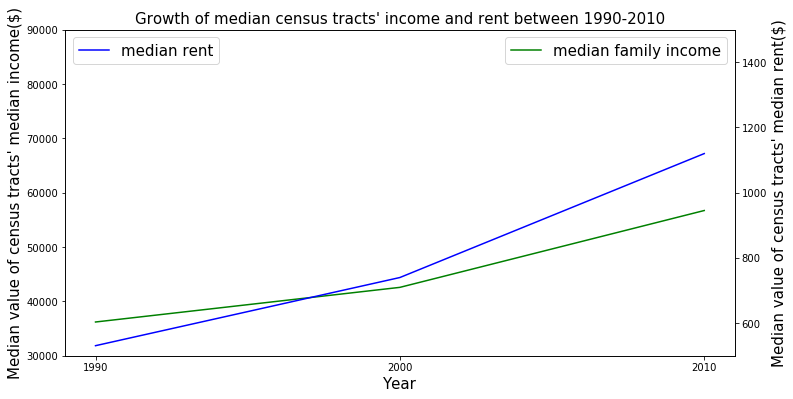

In [43]:
## select the median value of 2089 census tract
fig, ax1 = plt.subplots(figsize = (12, 6))
ax2 = ax1.twinx()
ax1.plot(np.arange(3), df2.median().iloc[[1,3,5]], c = 'g', label = 'median family income')
ax2.plot(np.arange(3), df2.median().iloc[[2,4,6]], c = 'b', label = 'median rent')
ax1.legend(loc = 'upper right', fontsize = 15)
ax2.legend(loc = 'upper left', fontsize = 15)

ax1.set_xlabel('Year', fontsize = 15)
ax1.set_ylabel("Median value of census tracts' median income($)", fontsize = 15)
ax1.set_ylim((30000,90000))

ax2.set_ylabel("Median value of census tracts' median rent($)", fontsize = 15)
ax2.set_ylim((500, 1500))

plt.xticks(np.arange(3), ('1990','2000','2010'))
plt.title("Growth of median census tracts' income and rent between 1990-2010", fontsize = 15)

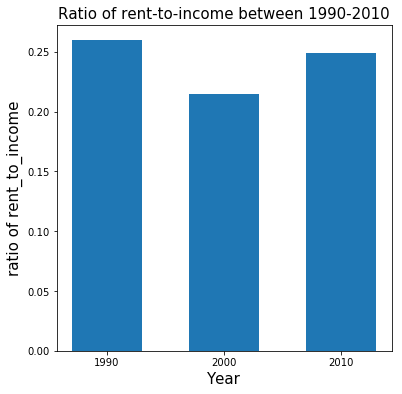

In [85]:
## see how does rent-to-income ratio change
plt.figure(figsize = (6, 6))
plt.bar(np.arange(3), df2.mean()[7:10], width = 0.6)

plt.xticks(np.arange(3), ('1990','2000','2010'))
plt.xlabel('Year', fontsize = 15)
plt.ylabel('ratio of rent_to_income', fontsize = 15)
plt.title('Ratio of rent-to-income between 1990-2010', fontsize = 15)

## Calculate the change of rent between 1990-2000 and 2000-2010

In [45]:
df2['inc_growth_90_00'] = df2.median_inc_fam_0/df2.median_inc_fam_9
df2['inc_growth_00_10'] = df2.median_inc_fam_1/df2.median_inc_fam_0

df2['rent_growth_90_00'] = df2.median_rent_0/df2.median_rent_9
df2['rent_growth_00_10'] = df2.median_rent_1/df2.median_rent_0
df2.head()

,census_tract,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1,inc_growth_90_00,inc_growth_00_10,rent_growth_90_00,rent_growth_00_10
1,36005000200,38711,742,50817,730,58368,1273,0.230012,0.172383,0.261719,1.312728,1.148592,0.983827,1.743836
2,36005000400,40484,535,41019,643,73148,1330,0.158581,0.188108,0.218188,1.013215,1.783271,1.201869,2.068429
3,36005001600,24732,466,30104,558,33555,823,0.226104,0.222429,0.294323,1.217208,1.114636,1.197425,1.474910
4,36005001900,24823,422,23671,461,25489,870,0.204004,0.233704,0.409588,0.953591,1.076803,1.092417,1.887202
5,36005002000,18762,298,19694,266,30817,455,0.190598,0.162080,0.177175,1.049675,1.564791,0.892617,1.710526


In [46]:
df2.describe()

,census_tract,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1,inc_growth_90_00,inc_growth_00_10,rent_growth_90_00,rent_growth_00_10
count,2.089000e+03,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000
mean,3.605455e+10,37689.401628,544.198181,48874.026807,753.071326,66207.958353,1151.020105,0.259635,0.214373,0.248931,2.017393,1.386582,1.394707,1.554580
std,2.594637e+07,18760.425689,150.069074,28645.098401,231.835763,39910.826453,331.293631,2.738330,0.074864,0.100567,32.109538,0.371344,0.243999,0.341645
min,3.600500e+10,86.000000,140.000000,7354.000000,175.000000,8542.000000,231.000000,0.067760,0.010500,0.042308,0.536671,0.210854,0.174825,0.326599
25%,3.604702e+10,24924.000000,453.000000,30724.000000,644.000000,40022.000000,964.000000,0.151078,0.164954,0.181756,1.100910,1.155940,1.272441,1.412500
50%,3.604712e+10,36218.000000,531.000000,42590.000000,740.000000,56726.000000,1120.000000,0.183705,0.204193,0.235058,1.250178,1.336591,1.378641,1.525917
75%,3.608103e+10,46843.000000,629.000000,58977.000000,834.000000,80125.000000,1308.000000,0.227210,0.253730,0.300615,1.426565,1.545935,1.486239,1.655766
max,3.608503e+10,150001.000000,1001.000000,200001.000000,2001.000000,250001.000000,2001.000000,125.302326,1.194452,1.298057,1468.779070,4.714033,4.547727,11.434286


## 2) Calculation of entropy index 
entropy index of different income-level groups for each census tract from 1990 to 2010

entropy index fomular:
https://github.com/picniclin/NYC_yl5240/blob/master/entropy_index_fomular.png

In [47]:
# define entropy index 
def entropy_index(x):
    Q_sum = 0
    for i in x:
        if i == 0:
            Q = 0
        else:
            Q = (-1) * (i/sum(x)) * np.log(i/sum(x))
        Q_sum += Q
    entropy_index = Q_sum/np.log(len(x))
    return entropy_index

In [48]:
# have a try
entropy_index(list(df_family_income_1990.iloc[0,1:]))

0.92246865765414721

In [49]:
# calculate the entropy index of 1990
for i in df_family_income_1990.index:
    df_family_income_1990.loc[i,'entropy_index_9'] = \
                    entropy_index(list(df_family_income_1990.loc[i,'fam_inc_109':'fam_inc_max_9']))

In [50]:
df_family_income_1990.head()

,census_tract,fam_inc_109,fam_inc_159,fam_inc_209,fam_inc_259,fam_inc_309,fam_inc_359,fam_inc_409,fam_inc_499,fam_inc_609,fam_inc_759,fam_inc_1009,fam_inc_1259,fam_inc_1509,fam_inc_max_9,entropy_index_9
0,36005000200,29,29,12,31,20,32,31,84,75,59,68,35,18,2,0.922469
1,36005000400,19,17,11,34,1,50,50,89,71,58,62,28,1,1,0.863543
2,36005001600,142,28,124,84,41,165,39,161,69,70,45,11,0,0,0.863912
3,36005001900,50,39,0,0,3,0,0,67,26,10,0,0,0,0,0.577145
4,36005002000,284,201,107,60,74,131,95,203,158,40,84,8,0,13,0.875156


In [51]:
# calculate the entropy index of 2000 and 2010
for i in df_family_income_2000.index:
    df_family_income_2000.loc[i,'entropy_index_0'] = \
                    entropy_index(list(df_family_income_2000.loc[i,'fam_inc_100':'fam_inc_max_200']))

for i in df_family_income_2010.index:
    df_family_income_2010.loc[i,'entropy_index_1'] = \
                    entropy_index(list(df_family_income_2010.loc[i,'fam_inc_101':'fam_inc_max_201']))

In [52]:
df_family_income_1990.shape, df_family_income_2000.shape, df_family_income_2010.shape

((2089, 16), (2089, 18), (2089, 18))

## Table of Census tract entropy index! That's what we need! The milestone!

In [53]:
df_census_entropy = df_dataset_tract.merge(pd.concat([df_family_income_1990.iloc[:,[0,-1]],
                              df_family_income_2000.iloc[:,-1],
                              df_family_income_2010.iloc[:,-1]], axis = 1), on = 'census_tract')

df_census_entropy.head()

,census_tract,Borough,PUMA,PUMA_CommunityDistrict,NTA_Code,NTA_Name,lat,lon,ZCTA5,entropy_index_9,entropy_index_0,entropy_index_1
0,36005000200,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.804573,-73.856859,10473,0.922469,0.871427,0.894048
1,36005000400,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.808915,-73.850488,10473,0.863543,0.914607,0.898725
2,36005001600,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.818848,-73.858076,10473,0.863912,0.902281,0.894488
3,36005001900,Bronx,3710,BX Community Districts 1 & 2,BX39,Mott Haven-Port Morris,40.800999,-73.909373,10454,0.577145,0.825729,0.842364
4,36005002000,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.817580,-73.866096,10473,0.875156,0.795292,0.918302


In [54]:
df_census_entropy.shape

(2089, 12)

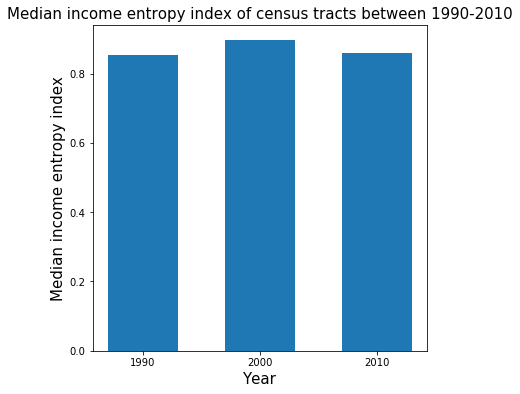

In [55]:
plt.figure(figsize = (6, 6))
plt.bar(np.arange(3), df_census_entropy.median()[-3:], width = 0.6)

plt.xticks(np.arange(3), ('1990','2000','2010'))
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Median income entropy index', fontsize = 15)
plt.title('Median income entropy index of census tracts between 1990-2010', fontsize = 15)

## 3) Combine entropy index and rent growth


In [56]:
sum(np.array(df_census_entropy == 0))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 2, 1])

In [57]:
## delete the observation with 0 entropy index
df_census_entropy1 = df_census_entropy[~((df_census_entropy.entropy_index_9 == 0)| (df_census_entropy.entropy_index_0 == 0)|\
                          (df_census_entropy.entropy_index_1 == 0))]

df_census_entropy1.shape, sum(np.array(df_census_entropy1 == 0))

((2080, 12), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

## This is the Table on Census tract level for entropy index and rent growth!

In [58]:
df_census_entropy_rent = df_census_entropy1.merge(df2.loc[:,['census_tract','rent_growth_90_00',
                                                             'rent_growth_00_10']], 
                                                  on = 'census_tract' )
    

df_census_entropy_rent.head()

,census_tract,Borough,PUMA,PUMA_CommunityDistrict,NTA_Code,NTA_Name,lat,lon,ZCTA5,entropy_index_9,entropy_index_0,entropy_index_1,rent_growth_90_00,rent_growth_00_10
0,36005000200,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.804573,-73.856859,10473,0.922469,0.871427,0.894048,0.983827,1.743836
1,36005000400,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.808915,-73.850488,10473,0.863543,0.914607,0.898725,1.201869,2.068429
2,36005001600,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.818848,-73.858076,10473,0.863912,0.902281,0.894488,1.197425,1.474910
3,36005001900,Bronx,3710,BX Community Districts 1 & 2,BX39,Mott Haven-Port Morris,40.800999,-73.909373,10454,0.577145,0.825729,0.842364,1.092417,1.887202
4,36005002000,Bronx,3709,BX Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.817580,-73.866096,10473,0.875156,0.795292,0.918302,0.892617,1.710526


In [59]:
df_census_entropy_rent.shape

(2080, 14)

In [60]:
df_census_entropy_rent.describe()

,census_tract,PUMA,lat,lon,ZCTA5,entropy_index_9,entropy_index_0,entropy_index_1,rent_growth_90_00,rent_growth_00_10
count,2.080000e+03,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000
mean,3.605454e+10,3959.710577,40.715837,-73.915934,10946.699519,0.837531,0.878937,0.837894,1.393492,1.550774
std,2.597060e+07,144.859288,0.084136,0.086686,502.490844,0.076998,0.066597,0.093337,0.235155,0.264145
min,3.600500e+10,3701.000000,40.499787,-74.243439,10001.000000,0.172632,0.362708,0.199940,0.624286,0.326599
25%,3.604702e+10,3808.000000,40.648835,-73.966621,10461.000000,0.811590,0.854212,0.804635,1.272691,1.412871
50%,3.604712e+10,4009.000000,40.705775,-73.919253,11214.000000,0.854884,0.896428,0.860526,1.378611,1.526301
75%,3.608103e+10,4103.000000,40.769151,-73.861136,11357.000000,0.885035,0.923663,0.899776,1.485551,1.655776
max,3.608503e+10,4114.000000,40.909668,-73.704608,11697.000000,0.962561,0.978050,0.979375,4.547727,4.600000


## 4) OLS regression between rent growth and entropy index, on census tract level

In [61]:
lm1 = smf.ols('rent_growth_90_00 ~ entropy_index_9', df_census_entropy_rent).fit()
lm2 = smf.ols('rent_growth_00_10 ~ entropy_index_0', df_census_entropy_rent).fit()

In [62]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      rent_growth_90_00   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     14.51
Date:                Wed, 15 Nov 2017   Prob (F-statistic):           0.000144
Time:                        14:25:31   Log-Likelihood:                 67.161
No. Observations:                2080   AIC:                            -130.3
Df Residuals:                    2078   BIC:                            -119.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           1.6065      0.056     28.609      0.000         1.496     1.717
entropy_index_9    -0.2543      0.067     -3.809      0.000        -0.385    -0.123
==============================================================================
Omnibus:                     1262.560   Durbin-Watson:                   1.604
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39327.293
Skew:                           2.323   Prob(JB):                         0.00
Kurtosis:                      23.789   Cond. No.                         22.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      rent_growth_00_10   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.395
Date:                Wed, 15 Nov 2017   Prob (F-statistic):             0.0655
Time:                        14:25:31   Log-Likelihood:                -180.18
No. Observations:                2080   AIC:                             364.4
Df Residuals:                    2078   BIC:                             375.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           1.6916      0.077     22.074      0.000         1.541     1.842
entropy_index_0    -0.1602      0.087     -1.843      0.066        -0.331     0.010
==============================================================================
Omnibus:                      858.727   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13975.251
Skew:                           1.508   Prob(JB):                         0.00
Kurtosis:                      15.335   Cond. No.                         26.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Rent_growth_90to00 = -0.254 * Tract_Entropy_Index_90 + 1.606, R-squared = 0.007


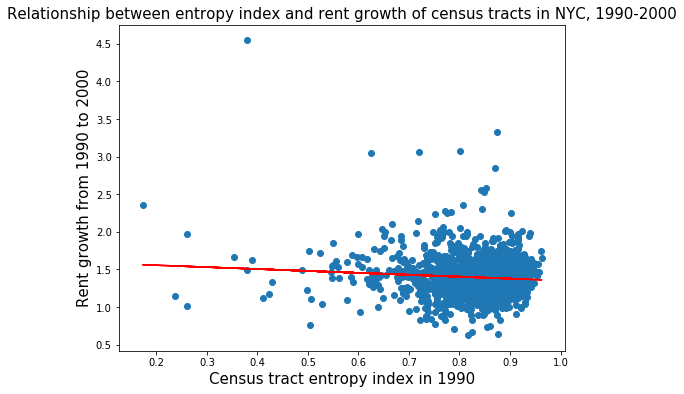

In [64]:
plt.figure(figsize = (8, 6))
plt.scatter(df_census_entropy_rent.entropy_index_9, df_census_entropy_rent.rent_growth_90_00)
plt.plot(df_census_entropy_rent.entropy_index_9, lm1.predict(), c = 'r')
plt.xlabel('Census tract entropy index in 1990', fontsize = 15)
plt.ylabel('Rent growth from 1990 to 2000', fontsize = 15)
plt.title('Relationship between entropy index and rent growth of census tracts in NYC, 1990-2000',
         fontsize = 15)

print('Rent_growth_90to00 = {} * Tract_Entropy_Index_90 + {}, R-squared = {}'.format(round(lm1.params[1],3),
                                                            round(lm1.params[0],3),round(lm1.rsquared,3)))

Rent_growth_00to10 = -0.16 * Tract_Entropy_Index_00 + 1.692, R-squared = 0.002


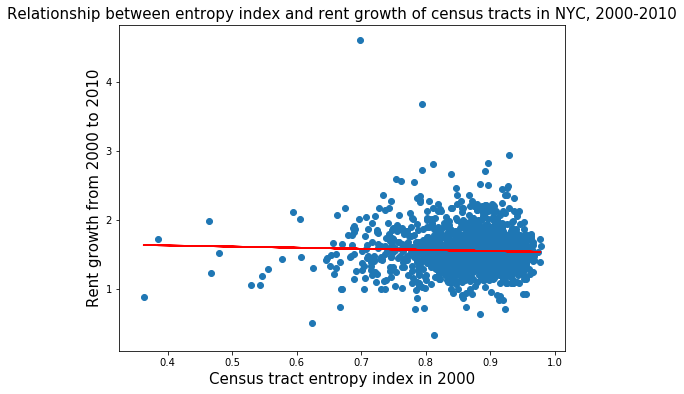

In [65]:
plt.figure(figsize = (8, 6))
plt.scatter(df_census_entropy_rent.entropy_index_0, df_census_entropy_rent.rent_growth_00_10)
plt.plot(df_census_entropy_rent.entropy_index_0, lm2.predict(), c = 'r')
plt.xlabel('Census tract entropy index in 2000', fontsize = 15)
plt.ylabel('Rent growth from 2000 to 2010', fontsize = 15)
plt.title('Relationship between entropy index and rent growth of census tracts in NYC, 2000-2010',
         fontsize = 15)

print('Rent_growth_00to10 = {} * Tract_Entropy_Index_00 + {}, R-squared = {}'.format(round(lm2.params[1],3),
                                                            round(lm2.params[0],3),round(lm2.rsquared,3)))

# 4. Analysis based on PUMA neighborhoods

### 1） the whole view

In [66]:
# the census tracts' median value of entropy index and rent growth
df_puma_median = df_census_entropy_rent.groupby(by = 'PUMA').median().iloc[:,-5:]
df_puma_median.head()

,entropy_index_9,entropy_index_0,entropy_index_1,rent_growth_90_00,rent_growth_00_10
PUMA,,,,,
3701,0.872680,0.893574,0.817017,1.434646,1.493617
3702,0.840885,0.900094,0.861965,1.356505,1.483344
3703,0.861089,0.913321,0.875237,1.342715,1.522135
3704,0.864330,0.902503,0.850050,1.395233,1.490328
3705,0.751176,0.810493,0.836372,1.399340,1.583062


In [67]:
df_puma_median.shape 

(55, 5)

In [68]:
df_puma_family_income = df_family_income.groupby(by = 'PUMA').sum()\
                                        .drop(['census_tract'], axis = 1)
df_puma_family_income.head()

,fam_inc_109,fam_inc_159,fam_inc_209,fam_inc_259,fam_inc_309,fam_inc_359,fam_inc_409,fam_inc_499,fam_inc_609,fam_inc_759,...,fam_inc_401,fam_inc_451,fam_inc_501,fam_inc_601,fam_inc_751,fam_inc_1001,fam_inc_1251,fam_inc_1501,fam_inc_2001,fam_inc_max_201
PUMA,,,,,,,,,,,,,,,,,,,,,
3701,1512,818,858,691,743,1769,1789,3103,2296,2672,...,1106,1033,875,1997,2480,3003,2440,1359,1350,1923
3702,1430,841,1058,1072,1117,2086,2150,4022,3266,2967,...,1793,1375,1531,2759,3667,5116,2928,1458,1478,495
3703,961,717,979,874,775,2037,2191,3827,3035,3658,...,1276,1386,1154,1952,3071,4514,3172,2069,1525,826
3704,1656,856,1013,969,1159,2035,1725,3363,2457,2783,...,1344,1404,1383,2680,3547,4051,2565,1453,1153,517
3705,5270,1273,1255,1270,770,1594,1029,1595,891,620,...,2134,1438,1374,2006,2054,1976,875,363,191,37


In [69]:
df_puma_family_income.shape

(55, 46)

In [119]:
df2.head()

,census_tract,PUMA,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1
0,36005000200,3709,38711,742,50817,730,58368,1273,0.230012,0.172383,0.261719
1,36005000400,3709,40484,535,41019,643,73148,1330,0.158581,0.188108,0.218188
2,36005001600,3709,24732,466,30104,558,33555,823,0.226104,0.222429,0.294323
3,36005001900,3710,24823,422,23671,461,25489,870,0.204004,0.233704,0.409588
4,36005002000,3709,18762,298,19694,266,30817,455,0.190598,0.162080,0.177175


In [122]:
df2_puma = df2.groupby(by = 'PUMA').median().iloc[:,1:]
df2_puma

,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1
PUMA,,,,,,,,,
3701,44167.0,494.0,51299.0,700.0,62159.0,1085.0,0.140436,0.166318,0.198781
3702,39708.5,531.5,46601.0,724.0,59099.5,1096.5,0.168343,0.193987,0.223715
3703,47155.0,575.0,52801.0,782.0,67596.0,1134.0,0.147156,0.170217,0.189952
3704,36393.5,523.5,40273.0,733.0,57014.0,1059.5,0.167861,0.194978,0.218396
3705,13400.0,356.0,19793.0,536.5,26319.5,837.5,0.308408,0.288862,0.369311
3706,25092.5,469.5,26736.0,680.5,33180.0,989.0,0.220778,0.306095,0.356087
3707,16148.0,444.0,21376.0,609.0,27788.0,926.0,0.335313,0.341879,0.377673
3708,15738.0,424.0,22161.0,602.0,30937.0,923.0,0.325504,0.320971,0.347526
3709,31619.0,465.0,35118.5,659.5,42323.5,1015.5,0.189547,0.219682,0.262219


In [ ]:
plt.

### We have 55 PUMAs for analysis.

## 2) Calculation of PUMA entropy index of 1990, 2000 and 2010

In [70]:

for i in df_puma_family_income.index:
    df_puma_family_income.loc[i,'entropy_index_9'] = \
                    entropy_index(list(df_puma_family_income.loc[i,'fam_inc_109':'fam_inc_max_9']))
    df_puma_family_income.loc[i,'entropy_index_0'] = \
                    entropy_index(list(df_puma_family_income.loc[i,'fam_inc_100':'fam_inc_max_200']))
    df_puma_family_income.loc[i,'entropy_index_1'] = \
                    entropy_index(list(df_puma_family_income.loc[i,'fam_inc_101':'fam_inc_max_201']))

In [71]:
df_puma_entropy = df_puma_family_income.loc[:, ['entropy_index_9',
                                           'entropy_index_0',
                                           'entropy_index_1']]
df_puma_entropy.head()

,entropy_index_9,entropy_index_0,entropy_index_1
PUMA,,,
3701,0.947997,0.971912,0.971036
3702,0.914075,0.952123,0.956327
3703,0.905603,0.938712,0.945460
3704,0.927587,0.952514,0.958739
3705,0.820355,0.831354,0.896695


In [72]:
df_puma_entropy.shape

(55, 3)

## 3) Combine PUMA entropy index and rent growth

In [73]:

df_puma_entropy_rent = pd.concat([df_puma_entropy, 
                df_puma_median.loc[:,['rent_growth_90_00','rent_growth_00_10']]],
                                axis = 1)
df_puma_entropy_rent.head()

,entropy_index_9,entropy_index_0,entropy_index_1,rent_growth_90_00,rent_growth_00_10
PUMA,,,,,
3701,0.947997,0.971912,0.971036,1.434646,1.493617
3702,0.914075,0.952123,0.956327,1.356505,1.483344
3703,0.905603,0.938712,0.945460,1.342715,1.522135
3704,0.927587,0.952514,0.958739,1.395233,1.490328
3705,0.820355,0.831354,0.896695,1.399340,1.583062


## This is the Table on PUMA level for entropy index and rent growth!

In [74]:
df_puma_entropy_rent = df_PUMA.merge(df_puma_entropy_rent.reset_index(), on = 'PUMA')
df_puma_entropy_rent

,PUMA,PUMA_CommunityDistrict,entropy_index_9,entropy_index_0,entropy_index_1,rent_growth_90_00,rent_growth_00_10
0,3701,BX Community District 8,0.947997,0.971912,0.971036,1.434646,1.493617
1,3702,BX Community District 12,0.914075,0.952123,0.956327,1.356505,1.483344
2,3703,BX Community District 10,0.905603,0.938712,0.945460,1.342715,1.522135
3,3704,BX Community District 11,0.927587,0.952514,0.958739,1.395233,1.490328
4,3705,BX Community Districts 3 & 6,0.820355,0.831354,0.896695,1.399340,1.583062
5,3706,BX Community District 7,0.888255,0.895277,0.940873,1.431044,1.444079
6,3707,BX Community District 5,0.823367,0.850516,0.910264,1.368421,1.541534
7,3708,BX Community District 4,0.866420,0.854337,0.925938,1.392936,1.503703
8,3709,BX Community District 9,0.911087,0.914658,0.964968,1.384615,1.519779
9,3710,BX Community Districts 1 & 2,0.775501,0.828306,0.900102,1.237976,1.703100


In [107]:
df_puma_entropy_rent['mean_entropy'] = (df_puma_entropy_rent.entropy_index_9 + \
 df_puma_entropy_rent.entropy_index_0 + \
 df_puma_entropy_rent.entropy_index_1)/3
                                                          

In [108]:
df_puma_entropy_rent

,PUMA,PUMA_CommunityDistrict,entropy_index_9,entropy_index_0,entropy_index_1,rent_growth_90_00,rent_growth_00_10,mean_entropy
0,3701,BX Community District 8,0.947997,0.971912,0.971036,1.434646,1.493617,0.963648
1,3702,BX Community District 12,0.914075,0.952123,0.956327,1.356505,1.483344,0.940842
2,3703,BX Community District 10,0.905603,0.938712,0.945460,1.342715,1.522135,0.929925
3,3704,BX Community District 11,0.927587,0.952514,0.958739,1.395233,1.490328,0.946280
4,3705,BX Community Districts 3 & 6,0.820355,0.831354,0.896695,1.399340,1.583062,0.849468
5,3706,BX Community District 7,0.888255,0.895277,0.940873,1.431044,1.444079,0.908135
6,3707,BX Community District 5,0.823367,0.850516,0.910264,1.368421,1.541534,0.861383
7,3708,BX Community District 4,0.866420,0.854337,0.925938,1.392936,1.503703,0.882232
8,3709,BX Community District 9,0.911087,0.914658,0.964968,1.384615,1.519779,0.930237
9,3710,BX Community Districts 1 & 2,0.775501,0.828306,0.900102,1.237976,1.703100,0.834636


In [75]:
df_puma_entropy_rent.shape

(55, 7)

In [76]:
df_puma_entropy_rent.describe()

,PUMA,entropy_index_9,entropy_index_0,entropy_index_1,rent_growth_90_00,rent_growth_00_10
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,3936.218182,0.904434,0.926655,0.936620,1.406098,1.538570
std,149.997616,0.038194,0.041904,0.058821,0.125154,0.091435
min,3701.000000,0.775501,0.799350,0.704571,1.200278,1.413202
25%,3804.500000,0.893855,0.900103,0.930343,1.341770,1.481341
50%,4005.000000,0.912587,0.945421,0.957218,1.394531,1.520751
75%,4059.500000,0.924997,0.955290,0.972830,1.432845,1.575999
max,4114.000000,0.966913,0.973947,0.981136,1.823978,1.821794


## 4) Have a look at the PUMA entropy index

The median values of income entropy index of PUMAs in 1999, 2000 and 2010 are respectively 0.913, 0.945 and 0.957.


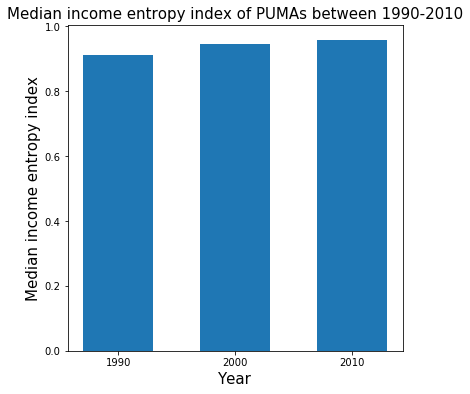

In [77]:
plt.figure(figsize = (6, 6))
plt.bar(np.arange(3), df_puma_entropy_rent.median()[1:4], width = 0.6)

plt.xticks(np.arange(3), ('1990','2000','2010'))
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Median income entropy index', fontsize = 15)
plt.title('Median income entropy index of PUMAs between 1990-2010', fontsize = 15)

print('The median values of income entropy index of PUMAs in 1999, 2000 and 2010 are respectively {}, {} and {}.'.\
      format(round(df_puma_entropy_rent.median()[1],3), 
             round(df_puma_entropy_rent.median()[2],3), 
             round(df_puma_entropy_rent.median()[3],3)))

## The income entropy index of PUMAs increased in the 20 years, meaning the level of neighborhood income integration in total has increased

### Then, we have a look at the variance of different PUMA's entropy index and their change in 20 years

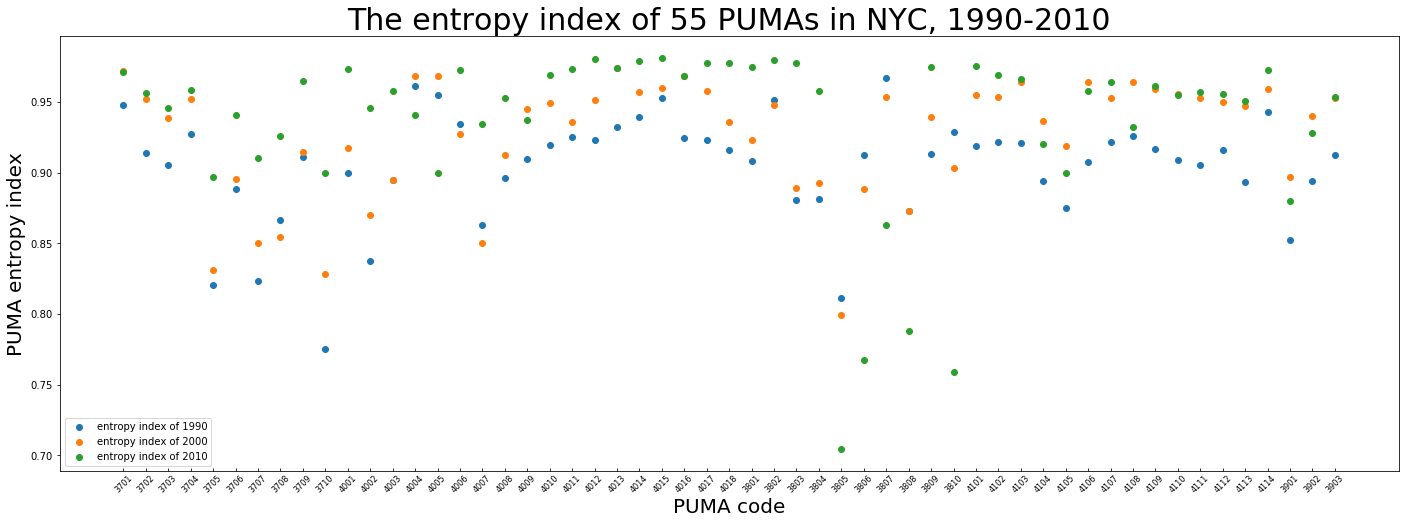

In [89]:
## to see the distribution of entropy index
plt.figure(figsize = (24, 8))
plt.scatter(np.arange(len(df_puma_entropy_rent)),df_puma_entropy_rent.entropy_index_9,
           label = 'entropy index of 1990')
plt.scatter(np.arange(len(df_puma_entropy_rent)),df_puma_entropy_rent.entropy_index_0,
           label = 'entropy index of 2000')
plt.scatter(np.arange(len(df_puma_entropy_rent)),df_puma_entropy_rent.entropy_index_1,
           label = 'entropy index of 2010')
plt.legend()

plt.xticks(np.arange(len(df_puma_entropy_rent)), df_puma_entropy_rent.PUMA, rotation = 45, 
                  fontsize = 15)
plt.tick_params(axis='x', pad = 2, labelsize = 8, direction = 'in')
plt.ylabel('PUMA entropy index', fontsize = 20)
plt.xlabel('PUMA code', fontsize = 20)
plt.title('The entropy index of 55 PUMAs in NYC, 1990-2010', fontsize = 30)
plt.show()

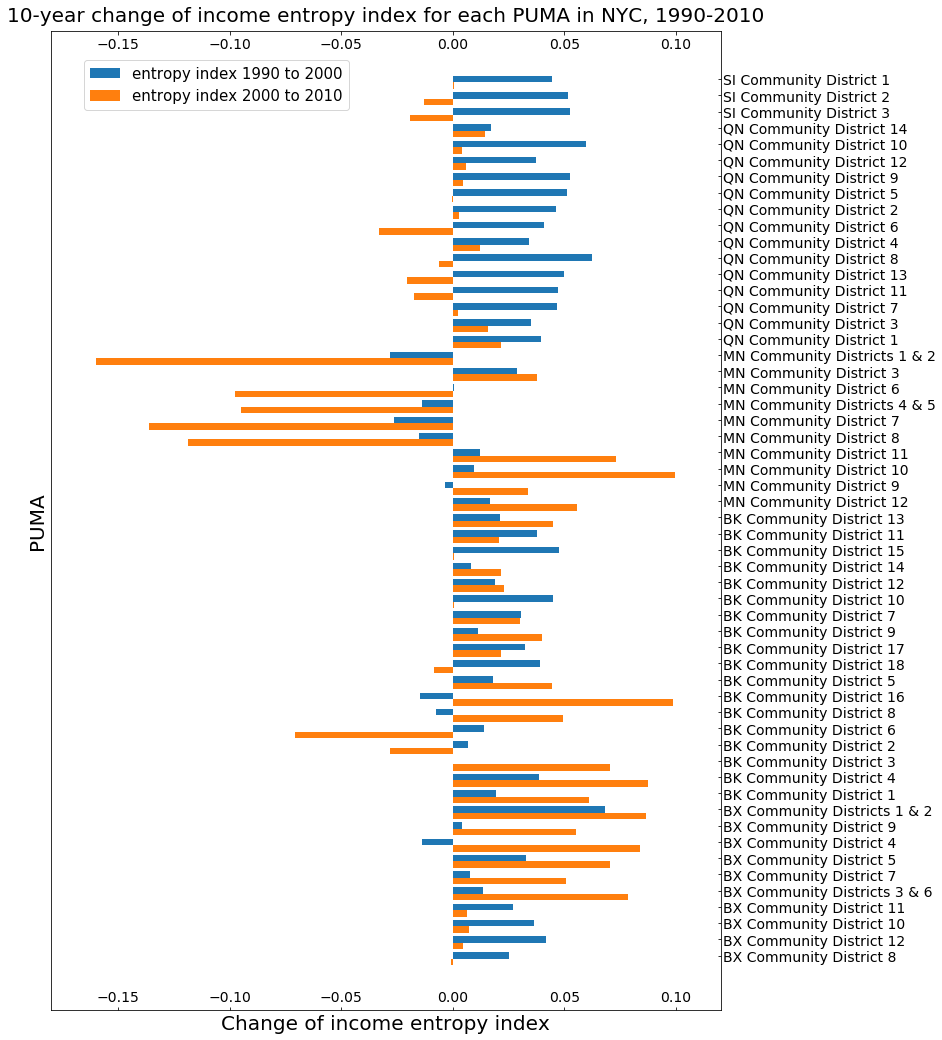

In [112]:
## To see the change of entropy index in the PUMAs
plt.figure(figsize = (12,18))
plt.barh(np.arange(len(df_puma_entropy_rent)), 
         width = df_puma_entropy_rent.entropy_index_0/df_puma_entropy_rent.entropy_index_9 - 1,
        height = 0.4, label = 'entropy index 1990 to 2000')
plt.barh(np.arange(len(df_puma_entropy_rent)) - 0.4, 
         width = df_puma_entropy_rent.entropy_index_1/df_puma_entropy_rent.entropy_index_0 - 1,
        height = 0.4, label = 'entropy index 2000 to 2010')
plt.xlim((-0.18,0.12))
plt.tick_params(axis='x', pad= -20, labelsize=14, direction = 'in', 
                top = True, bottom = True, labeltop= True, labelbottom = True)
plt.yticks(np.arange(len(df_puma_entropy_rent)),df_puma_entropy_rent.PUMA_CommunityDistrict )
plt.tick_params(axis='y', pad=2, labelsize=14, direction = 'in', 
               left = False, right = True, labelleft = False, labelright = True)

plt.ylabel('PUMA',fontsize = 20)
plt.xlabel('Change of income entropy index', fontsize = 20)
plt.title('10-year change of income entropy index for each PUMA in NYC, 1990-2010',fontsize = 20,
         verticalalignment='bottom')

plt.legend(loc = (0.05, 0.92), fontsize = 15)
plt.show()

## If we look at different PUMAs, the change of income entropy index varies, especially in Manhattan and Brooklyn.  
## In Manhattan, most of the entropy index continued to decrease in 20 years, even getting worse in the latter decade.
## On the contrary, in brooklyn, most of the entropy index continued to increase in 20 years, with greater growth rate in the latter decade.

## 5) OLS regression between rent growth and entropy index, on PUMA level

In [80]:
lm1_puma = smf.ols('rent_growth_90_00 ~ entropy_index_9', df_puma_entropy_rent).fit()
lm2_puma = smf.ols('rent_growth_00_10 ~ entropy_index_0', df_puma_entropy_rent).fit()

In [81]:
lm1_puma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      rent_growth_90_00   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     2.427
Date:                Wed, 15 Nov 2017   Prob (F-statistic):              0.125
Time:                        14:25:34   Log-Likelihood:                 37.996
No. Observations:                  55   AIC:                            -71.99
Df Residuals:                      53   BIC:                            -67.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.7859      0.398      1.973      0.054        -0.013     1.585
entropy_index_9     0.6857      0.440      1.558      0.125        -0.197     1.569
==============================================================================
Omnibus:                       17.513   Durbin-Watson:                   1.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.533
Skew:                           1.258   Prob(JB):                     2.11e-05
Kurtosis:                       4.751   Cond. No.                         48.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
lm2_puma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      rent_growth_00_10   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.1411
Date:                Wed, 15 Nov 2017   Prob (F-statistic):              0.709
Time:                        14:25:34   Log-Likelihood:                 54.103
No. Observations:                  55   AIC:                            -104.2
Df Residuals:                      53   BIC:                            -100.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           1.6428      0.278      5.917      0.000         1.086     2.200
entropy_index_0    -0.1125      0.299     -0.376      0.709        -0.713     0.488
==============================================================================
Omnibus:                       15.934   Durbin-Watson:                   1.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.507
Skew:                           1.197   Prob(JB):                     9.58e-05
Kurtosis:                       4.532   Cond. No.                         44.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Rent_growth_90to00 = 0.786 + 0.686 * PUMA_Entropy_Index_90, R-squared = 0.044


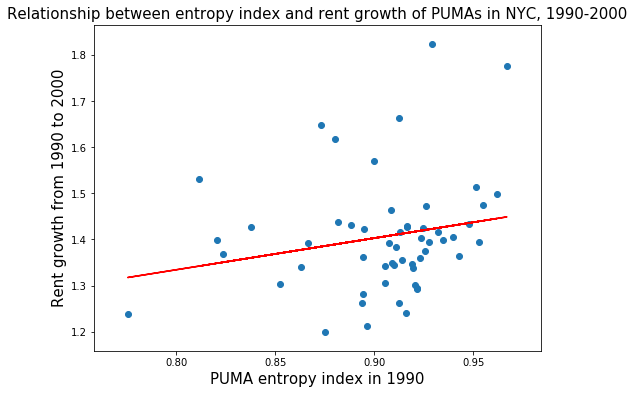

In [83]:
plt.figure(figsize = (8, 6))
plt.scatter(df_puma_entropy_rent.entropy_index_9, df_puma_entropy_rent.rent_growth_90_00)
plt.plot(df_puma_entropy_rent.entropy_index_9, lm1_puma.predict(), c = 'r')
plt.xlabel('PUMA entropy index in 1990', fontsize = 15)
plt.ylabel('Rent growth from 1990 to 2000', fontsize = 15)
plt.title('Relationship between entropy index and rent growth of PUMAs in NYC, 1990-2000',
         fontsize = 15)

print('Rent_growth_90to00 = {} + {} * PUMA_Entropy_Index_90, R-squared = {}'.format(\
                round(lm1_puma.params[0],3), round(lm1_puma.params[1],3),round(lm1_puma.rsquared,3)))

Rent_growth_00to10 = 1.643 + -0.112 * PUMA_Entropy_Index_00, R-squared = 0.003


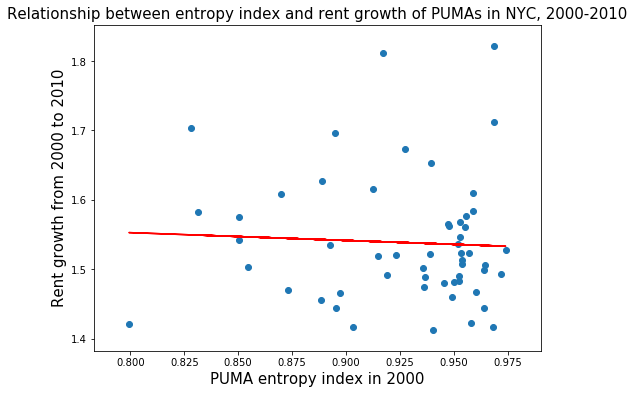

In [84]:
plt.figure(figsize = (8, 6))
plt.scatter(df_puma_entropy_rent.entropy_index_0, df_puma_entropy_rent.rent_growth_00_10)
plt.plot(df_puma_entropy_rent.entropy_index_0, lm2_puma.predict(), c = 'r')
plt.xlabel('PUMA entropy index in 2000', fontsize = 15)
plt.ylabel('Rent growth from 2000 to 2010', fontsize = 15)
plt.title('Relationship between entropy index and rent growth of PUMAs in NYC, 2000-2010',
         fontsize = 15)

print('Rent_growth_00to10 = {} + {} * PUMA_Entropy_Index_00, R-squared = {}'.format(\
                round(lm2_puma.params[0],3), round(lm2_puma.params[1],3),round(lm2_puma.rsquared,3)))

In [130]:
df2_puma2 = df2_puma[['median_inc_fam_9', 'median_inc_fam_0', 'median_inc_fam_1']]
df2_puma2.head()

,median_inc_fam_9,median_inc_fam_0,median_inc_fam_1
PUMA,,,
3701,44167.0,51299.0,62159.0
3702,39708.5,46601.0,59099.5
3703,47155.0,52801.0,67596.0
3704,36393.5,40273.0,57014.0
3705,13400.0,19793.0,26319.5


In [135]:
def outlier(x):
    outlier = np.mean(x) + 2 * np.std(x)
    return outlier

In [ ]:
np.mean(df2_puma2.median_inc_fam_9)

In [137]:
df2_puma2[~(df2_puma2.median_inc_fam_9 < outlier(df2_puma2.median_inc_fam_9))]

,median_inc_fam_9,median_inc_fam_0,median_inc_fam_1
PUMA,,,
3805,88298.0,143223.0,205250.0
3808,75619.0,108266.0,151267.0
3810,68911.0,119064.0,163000.0


In [129]:
df_all_2 = df2_puma.merge(df_puma_entropy_rent, left_index =True, right_on = 'PUMA')
df_all_2.head()

,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1,PUMA,PUMA_CommunityDistrict,entropy_index_9,entropy_index_0,entropy_index_1,rent_growth_90_00,rent_growth_00_10,mean_entropy
0,44167.0,494.0,51299.0,700.0,62159.0,1085.0,0.140436,0.166318,0.198781,3701,BX Community District 8,0.947997,0.971912,0.971036,1.434646,1.493617,0.963648
1,39708.5,531.5,46601.0,724.0,59099.5,1096.5,0.168343,0.193987,0.223715,3702,BX Community District 12,0.914075,0.952123,0.956327,1.356505,1.483344,0.940842
2,47155.0,575.0,52801.0,782.0,67596.0,1134.0,0.147156,0.170217,0.189952,3703,BX Community District 10,0.905603,0.938712,0.945460,1.342715,1.522135,0.929925
3,36393.5,523.5,40273.0,733.0,57014.0,1059.5,0.167861,0.194978,0.218396,3704,BX Community District 11,0.927587,0.952514,0.958739,1.395233,1.490328,0.946280
4,13400.0,356.0,19793.0,536.5,26319.5,837.5,0.308408,0.288862,0.369311,3705,BX Community Districts 3 & 6,0.820355,0.831354,0.896695,1.399340,1.583062,0.849468
